In [15]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
from skrf.media import *
import json

(4.0, 9.0)

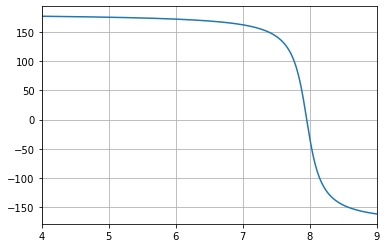

In [16]:
fghz  = np.linspace(4,9,1601)
f = fghz*1e9
sopen = fghz*0j + 1
open_network = rf.Network(frequency=f, s=sopen, z0=50)
C_shunt = 10e-12 # farads
L_shunt = 40e-12 # henries
omega = 2*np.pi*f
Y_c_shunt = 1j*omega*C_shunt
Y_l_shunt = 1/(1j*omega*L_shunt)
c_in = 1.5e-12
Z_c_in = 1/(1j*2*np.pi*f)
c_shunt_network = rf.Circuit.ShuntAdmittance(f, Y_c_shunt, name='shunt_admittance')
l_shunt_network = rf.Circuit.ShuntAdmittance(f, Y_l_shunt, name='shunt_admittance2')
cin_series_network = rf.Circuit.SeriesImpedance(f,Z_c_in,name='cin')
jpa = cin_series_network**l_shunt_network**c_shunt_network**open_network
plt.plot(fghz,jpa.s_deg_unwrap[:,0,0])
plt.grid()
plt.xlim(4,9)

In [44]:
generic_media = media.DefinedGammaZ0(z0_port=None, z0=50, gamma=1j)

In [49]:
line_length = generic_media.line(100, unit = 'mm', z0 = 50, name = '70 mm, 50 Ohm')

In [46]:
line_length

2-Port Network: '70 mm, 50 Ohm',  1.0-10.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j]

In [40]:
foo =line_length**jpa

In [42]:
len(foo.s_deg_unwrap)

8